# Rain Rate retrieval with Py-ART

In this notebook, an ODIM_H5 file is read using BALTRAD. Then the rain rate is determined from the calculated specific attenuation using Py-ART.
This is a severe flooding case from July 8, 2013 in Toronto, Canada, with radar data from the King City, Ontario, radar.

## retrieve data from s3 bucket

In [1]:
import os
import urllib.request
from pathlib import Path

# Set the URL for the cloud
URL = "https://js2.jetstream-cloud.org:8001/"
path = "pythia/radar/erad2024/baltrad/pyart2baltrad"
!mkdir -p data
files = ["WKR_201307082030.h5"]
for file in files:
    file0 = os.path.join(path, file)
    name = os.path.join("data", Path(file).name)
    if not os.path.exists(name):
        print(f"downloading, {name}")
        urllib.request.urlretrieve(f"{URL}{file0}", name)

downloading, data/WKR_201307082030.h5


In [2]:
%matplotlib inline

Import the necessary modules.

In [3]:
import numpy as np
import pyart
import baltrad_pyart_bridge as bridge  # routines to pass data from Py-ART and BALTRAD
import _raveio  # BALTRAD's input/output module
import cmweather


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



Read in the data using RAVE (a component of BALTRAD)

# Rain rate retrieval using specific attenuation using BALTRAD and Py-ART

In [4]:
rio = _raveio.open("data/WKR_201307082030.h5")

Convert the data to a Py-ART Radar object.

In [5]:
radar = bridge.raveio2radar(rio)

Examine some of the radar moments.

In [6]:
display = pyart.graph.RadarDisplay(radar)

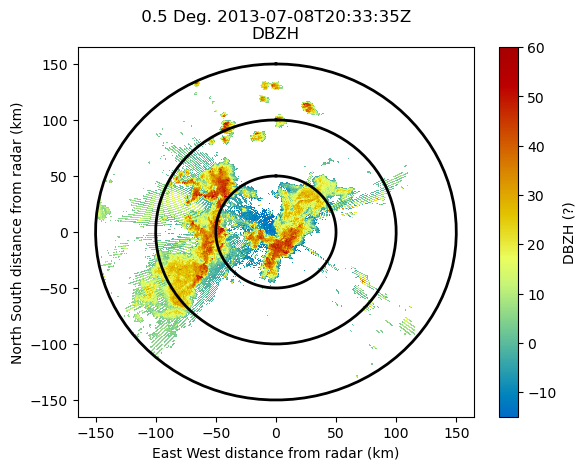

In [7]:
display.plot_ppi("DBZH", 0, vmin=-15, vmax=60)
display.plot_range_rings([50, 100, 150])

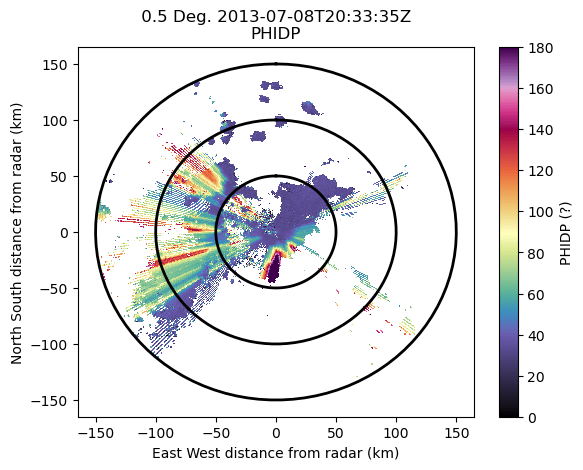

In [8]:
display.plot_ppi("PHIDP", 0, vmin=0, vmax=180, cmap="ChaseSpectral")
display.plot_range_rings([50, 100, 150])

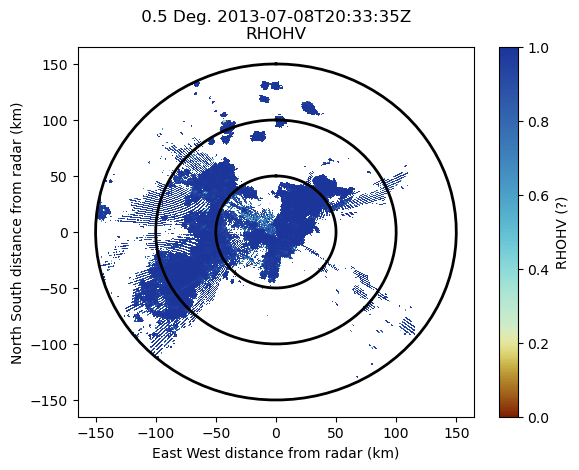

In [9]:
display.plot_ppi("RHOHV", 0, vmin=0, vmax=1.0, mask_outside=False, cmap="CM_rhohv")
display.plot_range_rings([50, 100, 150])

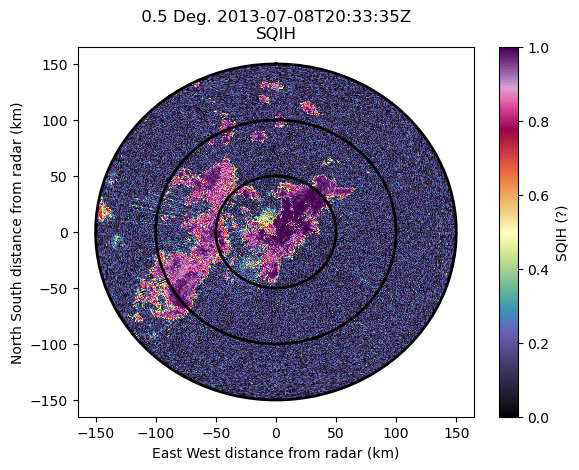

In [10]:
display.plot_ppi("SQIH", 0, vmin=0, vmax=1, mask_outside=False, cmap="ChaseSpectral")
display.plot_range_rings([50, 100, 150])

Calculate the specific attenuation and attenuation corrected reflectivity using Py-ART, add these field to the radar object.

In [11]:
radar.info()

altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: Altitude
	standard_name: Altitude
	units: meters
	positive: up
altitude_agl: None
antenna_transition: None
azimuth:
	data: <ndarray of type: float32 and shape: (720,)>
	units: degrees
	standard_name: beam_azimuth_angle
	long_name: azimuth_angle_from_true_north
	axis: radial_azimuth_coordinate
	comment: Azimuth of antenna relative to true north
elevation:
	data: <ndarray of type: float32 and shape: (720,)>
	units: degrees
	standard_name: beam_elevation_angle
	long_name: elevation_angle_from_horizontal_plane
	axis: radial_elevation_coordinate
	comment: Elevation of antenna relative to the horizontal plane
fields:
	DBZH:
		data: <ndarray of type: float32 and shape: (720, 600)>
	RHOHV:
		data: <ndarray of type: float32 and shape: (720, 600)>
	WRADH:
		data: <ndarray of type: float32 and shape: (720, 600)>
	PHIDP:
		data: <ndarray of type: float32 and shape: (720, 600)>
	ZDR:
		data: <ndarray of type: float32 and shape:

In [12]:
spec_at, cor_z = pyart.correct.calculate_attenuation(
    radar,
    0,
    doc=0,
    refl_field="DBZH",
    ncp_field="SQIH",
    rhv_field="RHOHV",
    phidp_field="PHIDP",
    fzl=8000,
)
# use the parameter below for a more 'cleanup up' attenuation field
# ncp_min=-1, rhv_min=-1)

In [13]:
radar.info()

altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: Altitude
	standard_name: Altitude
	units: meters
	positive: up
altitude_agl: None
antenna_transition: None
azimuth:
	data: <ndarray of type: float32 and shape: (720,)>
	units: degrees
	standard_name: beam_azimuth_angle
	long_name: azimuth_angle_from_true_north
	axis: radial_azimuth_coordinate
	comment: Azimuth of antenna relative to true north
elevation:
	data: <ndarray of type: float32 and shape: (720,)>
	units: degrees
	standard_name: beam_elevation_angle
	long_name: elevation_angle_from_horizontal_plane
	axis: radial_elevation_coordinate
	comment: Elevation of antenna relative to the horizontal plane
fields:
	DBZH:
		data: <ndarray of type: float32 and shape: (720, 600)>
	RHOHV:
		data: <ndarray of type: float32 and shape: (720, 600)>
	WRADH:
		data: <ndarray of type: float32 and shape: (720, 600)>
	PHIDP:
		data: <ndarray of type: float32 and shape: (720, 600)>
	ZDR:
		data: <ndarray of type: float32 and shape:

In [14]:
radar.add_field("specific_attenuation", spec_at)
radar.add_field("corrected_reflectivity", cor_z)

Examine these two new fields.

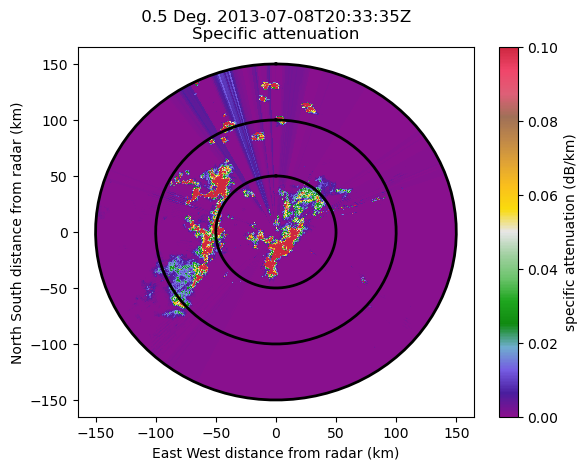

In [15]:
display.plot_ppi("specific_attenuation", 0, vmin=0, vmax=0.1)
display.plot_range_rings([50, 100, 150])

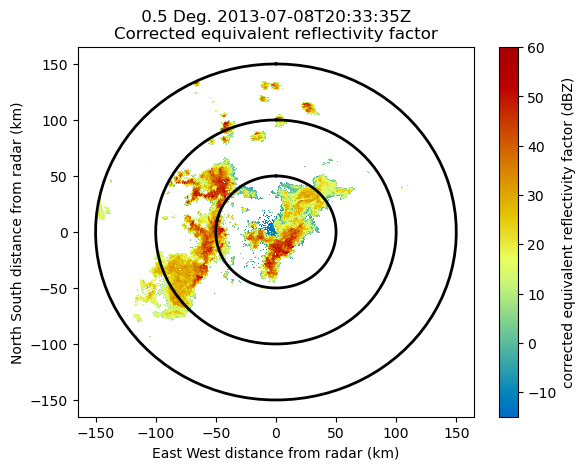

In [16]:
display.plot_ppi("corrected_reflectivity", 0, vmin=-15, vmax=60)
display.plot_range_rings([50, 100, 150])

Calculate the rain rate from the specific attenuation using a power law determined from the ARM Southern Great Plains site.  Mask values where the attenuation is not valid (when the cross correlation ratio or signal quality is low). Add this field to the radar object.

In [17]:
R = 300.0 * (radar.fields["specific_attenuation"]["data"]) ** 0.89
rain_rate_dic = pyart.config.get_metadata("rain_rate")
rain_rate_dic["units"] = "mm/hr"
rate_not_valid = np.logical_or(
    (radar.fields["SQIH"]["data"] < 0.4), (radar.fields["RHOHV"]["data"] < 0.8)
)
rain_rate_dic["data"] = np.ma.masked_where(rate_not_valid, R)
# fill the missing values with 0 for a nicer plot
rain_rate_dic["data"] = np.ma.filled(rain_rate_dic["data"], 0)

In [18]:
radar.add_field("RATE", rain_rate_dic)

Examine the rain rate

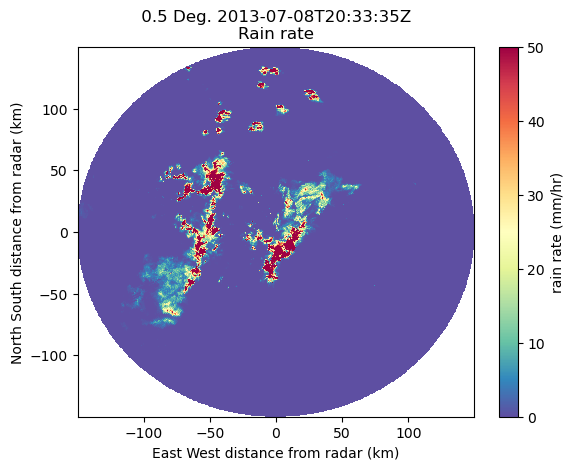

In [19]:
display.plot_ppi("RATE", 0, vmin=0, vmax=50.0)

Create a new RaveIO object from the Py-ART radar object and write this out using Rave

In [20]:
rio_out = bridge.radar2raveio(radar)

In [21]:
container = _raveio.new()
container.object = rio_out.object
container.save("data/WKR_201307082030_with_rain_rate.h5")

import os

print(
    "ODIM_H5 file is %i bytes large"
    % os.path.getsize("data/WKR_201307082030_with_rain_rate.h5")
)

ODIM_H5 file is 6259795 bytes large
